<a href="https://colab.research.google.com/github/federicochiarello/Hands-On-ML-Notebooks/blob/master/14_Deep_Computer_Vision_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

In [62]:
# Utility functions

def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')

def plot_color_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')

def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['loss'], label='loss')
    plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
    plt.title('loss')
    plt.legend()
  
def plot_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
    plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
    plt.title('accuracy')
    plt.legend()

# Basic CNN
On Fashion MNIST dataset



In [17]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True)
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [19]:
from functools import partial 

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding='SAME')

In [23]:
model = Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),

    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=10, activation='softmax')
])

In [24]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
157/157 [==============================] - 16s 17ms/step - loss: 1.5352 - accuracy: 0.4504 - val_loss: 1.1679 - val_accuracy: 0.6146
Epoch 2/10
157/157 [==============================] - 2s 13ms/step - loss: 0.9274 - accuracy: 0.6764 - val_loss: 0.7070 - val_accuracy: 0.7678
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 0.7393 - accuracy: 0.7346 - val_loss: 0.5759 - val_accuracy: 0.7928
Epoch 4/10
157/157 [==============================] - 2s 11ms/step - loss: 0.6597 - accuracy: 0.7726 - val_loss: 0.6059 - val_accuracy: 0.7882
Epoch 5/10
157/157 [==============================] - 2s 11ms/step - loss: 0.5836 - accuracy: 0.7950 - val_loss: 0.6048 - val_accuracy: 0.8030
Epoch 6/10
157/157 [==============================] - 2s 11ms/step - loss: 0.5337 - accuracy: 0.8116 - val_loss: 0.4870 - val_accuracy: 0.8304
Epoch 7/10
157/157 [==============================] - 2s 11ms/step - loss: 0.4740 - accuracy: 0.8308 - val_loss: 0.6791 - val_accuracy: 0.766

In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4862 - accuracy: 0.8475


[0.48621881008148193, 0.8475000262260437]

# CNN Architectures

## Residual Unit
ResNet-34 on CIFAR-10 dataset

In [29]:
(X_train_full, y_train_full), (X_test, y_test) = (keras.datasets.cifar10.load_data())

X_valid, X_train = X_train_full[:5000], X_train_full[5000:] 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

170508288/170498071 [==============================] - 13s 0us/step


In [30]:
mean = np.mean(X_train, axis=0)
standard_deviation = np.std(X_train, axis=0)

X_train = (X_train - mean) / standard_deviation
X_valid = (X_valid - mean) / standard_deviation
X_test = (X_test - mean) / standard_deviation

In [34]:
from keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D

In [26]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, 
                        padding='SAME', use_bias=False)

In [56]:
class ResidualUnit(keras.layers.Layer):

    """
    Residual Units (RUs) 
    implementation of skip connections

    Each Residual Unit is composed of two convolutional layers, Batch Normalization layer, ReLU activation.
    They use 3x3 kernels and preserves spatial dimensions (stride=1, padding='SAME')

    RU:
        Conv2D
        BatchNormalization
        ReLU
        Conv2D
        BatchNormalization
        (addition with skip_input)
        ReLU
        
    Exception: strides > 2

    --> In the ResNet-34 implementation the number of feature maps is doubled every
        few residual units and at the same time the height and width are halved

    If we use (strides == 2) the first internal Conv2D layer will halved the 
    height and width of the outputted feature maps.
    In order to be able to sum the skip_input with those feature maps we need to pass the 
    input through a 1x1 Conv2D with stride 2 and the right number of feature maps.

    """

    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            BatchNormalization(),
            self.activation, 
            DefaultConv2D(filters),
            BatchNormalization()
        ]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                BatchNormalization()
            ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
        

In [67]:
from keras.layers.pooling import GlobalAveragePooling2D
model = Sequential([
    DefaultConv2D(64, kernel_size=5, strides=1, input_shape=[32, 32, 3]),
    BatchNormalization(),
    Activation('relu'),
    # MaxPooling2D(pool_size=3, strides=2, padding='SAME'),

    ResidualUnit(filters=64),
    ResidualUnit(filters=64),
    ResidualUnit(filters=128, strides=2),
    ResidualUnit(filters=128),

    GlobalAveragePooling2D(),
    Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    Dense(10, activation='softmax') 
])

In [68]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 32, 32, 64)        4800      
                                                                 
 batch_normalization_107 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_9 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 residual_unit_44 (ResidualU  (None, 32, 32, 64)       74240     
 nit)                                                            
                                                                 
 residual_unit_45 (ResidualU  (None, 32, 32, 64)       74240     
 nit)                                                            
                                                      

In [69]:
# keras.utils.plot_model(model, show_shapes=True, to_file='residual_module.png')

In [70]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [71]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
1407/1407 [==============================] - 33s 21ms/step - loss: 1.6477 - accuracy: 0.3817 - val_loss: 1.7178 - val_accuracy: 0.3964
Epoch 2/15
1407/1407 [==============================] - 30s 21ms/step - loss: 1.2243 - accuracy: 0.5570 - val_loss: 1.7376 - val_accuracy: 0.4614
Epoch 3/15
1407/1407 [==============================] - 30s 21ms/step - loss: 1.0169 - accuracy: 0.6347 - val_loss: 0.8483 - val_accuracy: 0.6958
Epoch 4/15
1407/1407 [==============================] - 30s 21ms/step - loss: 0.8873 - accuracy: 0.6826 - val_loss: 0.8147 - val_accuracy: 0.7020
Epoch 5/15
1407/1407 [==============================] - 29s 21ms/step - loss: 0.7851 - accuracy: 0.7257 - val_loss: 0.7820 - val_accuracy: 0.7256
Epoch 6/15
1407/1407 [==============================] - 30s 21ms/step - loss: 0.7002 - accuracy: 0.7553 - val_loss: 0.6955 - val_accuracy: 0.7542
Epoch 7/15
1407/1407 [==============================] - 29s 21ms/step - loss: 0.6176 - accuracy: 0.7874 - val_loss: 0.8178 -

In [72]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.5037 - accuracy: 0.8364


[0.5036720633506775, 0.8363999724388123]

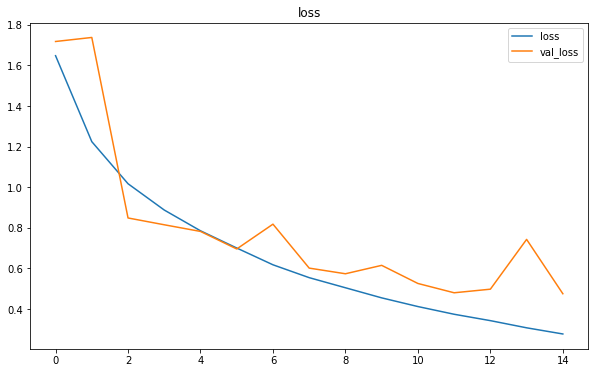

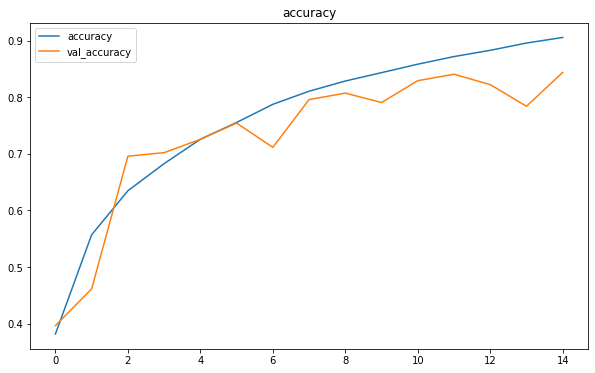

In [73]:
plot_loss(history)
plot_accuracy(history)

## Inception Module
GoogLeNet

In [ ]:
# # example of creating a CNN with an efficient inception module
# from keras.models import Model
# from keras.layers import Input
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers.merge import concatenate
# from keras.utils import plot_model
 
# # function for creating a projected inception module
# def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
# 	# 1x1 conv
# 	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
# 	# 3x3 conv
# 	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
# 	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
# 	# 5x5 conv
# 	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
# 	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
# 	# 3x3 max pooling
# 	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
# 	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
# 	# concatenate filters, assumes filters/channels last
# 	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
# 	return layer_out
 
# # define model input
# visible = Input(shape=(256, 256, 3))
# # add inception block 1
# layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# # add inception block 1
# layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# # create model
# model = Model(inputs=visible, outputs=layer)
# # summarize model
# model.summary()
# # plot model architecture
# plot_model(model, show_shapes=True, to_file='inception_module.png')

## Xception

# Pretrained Models

# Transfer Learning